# 1. Data Imports and setting environment

**Project:** Predicting ventilator requirements for COVID‑19 (Target: `INTUBATED`)  
**Notebook:** `05_evaluation.ipynb` (Final evaluation + results summary)  

> **Goal:** Consolidate results from baseline and tuned models, perform final held‑out evaluation, and generate publication‑quality tables/figures saved to `notebooks/outputs/`.


In [1]:
# ---------------------------------------------------------------------
# 1.1 Imports
# ---------------------------------------------------------------------
from __future__ import annotations

from pathlib import Path
import json
import warnings
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


In [ ]:
# ---------------------------------------------------------------------
# 1.2 Reproducibility + paths
# ---------------------------------------------------------------------
SEED = 42
np.random.seed(SEED)

PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUTPUT_DIR = PROJECT_ROOT / "outputs"
FIG_DIR = OUTPUT_DIR / "figures"

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Inputs produced by prior notebooks
BASELINE_METRICS_PATH = OUTPUT_DIR / "baseline_metrics.csv"
FINAL_MODEL_PATH = OUTPUT_DIR / "final_model.pkl"
FINAL_MODEL_META_PATH = OUTPUT_DIR / "final_model_meta.json"

# Choose dataset variant for final evaluation (should match training in 04)
DATASET_VARIANT = "dataset_v2_severity.parquet"
DATA_PATH = OUTPUT_DIR / DATASET_VARIANT

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_PATH:", DATA_PATH)
print("FINAL_MODEL_PATH:", FINAL_MODEL_PATH)


# 2.0 Load Artefacts and Dataset

This notebook expects artefacts produced in earlier stages:

- Cleaned / engineered dataset variant (from `03_feature_engineering.ipynb`)
- Baseline metrics (from `02_baseline_model.ipynb`)
- Tuned final model (from `04_smote_cv_optuna.ipynb`)

If you used a different dataset variant or tuning strategy in notebook 04, update `DATASET_VARIANT` above.


In [3]:
# ---------------------------------------------------------------------
# 2.1 Load dataset variant
# ---------------------------------------------------------------------
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Missing dataset at {DATA_PATH}. "
        "Run 03_feature_engineering.ipynb first, or update DATASET_VARIANT."
    )

df = pd.read_parquet(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (192706, 24)


,usmer,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnant,diabetes,copd,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu,comorbidity_count,severity_score,intubated
0,0,1,0,0,09/06/2020,1,0,55,97,1,2,2,2,2,2,2,2,2,2,3,2,0,0,1
1,0,1,1,0,9999-99-99,0,1,40,2,2,2,2,2,2,2,2,2,2,2,3,2,0,1,0
2,0,1,1,0,9999-99-99,0,0,37,2,1,2,2,2,1,2,2,1,2,2,3,2,0,0,0
3,0,1,1,0,9999-99-99,0,0,25,2,2,2,2,2,2,2,2,2,2,2,3,2,0,0,0
4,0,1,0,0,9999-99-99,0,0,24,97,2,2,2,2,2,2,2,2,2,2,3,2,0,0,0


In [4]:
# ---------------------------------------------------------------------
# 2.2 Load baseline metrics (if available)
# ---------------------------------------------------------------------
baseline_df = None
if BASELINE_METRICS_PATH.exists():
    baseline_df = pd.read_csv(BASELINE_METRICS_PATH)
    display(baseline_df)
else:
    print("Baseline metrics file not found:", BASELINE_METRICS_PATH.name)


,model,f1,recall,precision,pr_auc,n_train,n_test,positive_rate_train,positive_rate_test
0,XGBoost (baseline),1.0,1.0,1.0,1.0,154164,38542,0.174652,0.174641


In [5]:
# ---------------------------------------------------------------------
# 2.3 Load final model + metadata
# ---------------------------------------------------------------------
import joblib

if not FINAL_MODEL_PATH.exists():
    raise FileNotFoundError(
        f"Missing final model at {FINAL_MODEL_PATH}. "
        "Run 04_smote_cv_optuna.ipynb first."
    )

final_model = joblib.load(FINAL_MODEL_PATH)
print("Loaded final model.")

final_meta = {}
if FINAL_MODEL_META_PATH.exists():
    with open(FINAL_MODEL_META_PATH, "r") as f:
        final_meta = json.load(f)
final_meta


Loaded final model.


{'created_utc': '2026-01-11T03:35:46Z',
 'seed': 42,
 'dataset_variant': 'dataset_v2_severity.parquet',
 'tune_strategy': 'smote',
 'best_params': {'n_estimators': 207,
  'max_depth': 4,
  'learning_rate': 0.011158374754385829,
  'subsample': 0.9028683501145927,
  'colsample_bytree': 0.8988449120235339,
  'min_child_weight': 0.5393730428949445,
  'gamma': 0.09731761863870503,
  'reg_lambda': 3.064528529723978},
 'cv_best_value_f1': 0.3650288087505965}

# 3.0 Held‑Out Evaluation Protocol

We evaluate the tuned model on a **held‑out test split** for an unbiased estimate of performance.

**Process:**
1. Create a stratified train/test split
2. Fit the tuned pipeline on the training split
3. Evaluate on the test split
4. Perform threshold analysis to trade off recall vs precision

> Note: If your earlier notebooks used a specific split strategy, keep the same `test_size` and `random_state` for consistency.


In [6]:
# ---------------------------------------------------------------------
# 3.1 Split target/features
# ---------------------------------------------------------------------
TARGET = "intubated"
if TARGET not in df.columns:
    raise KeyError(f"Expected target column '{TARGET}' not found.")

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train size:", X_train.shape, " Pos rate:", (y_train==1).mean())
print("Test size :", X_test.shape,  " Pos rate:", (y_test==1).mean())


Train size: (154164, 23)  Pos rate: 0.17465166965050205
Test size : (38542, 23)  Pos rate: 0.17464065175652535


In [7]:
# ---------------------------------------------------------------------
# 3.2 Fit tuned model on training split
# ---------------------------------------------------------------------
# The saved model is a pipeline; we re-fit it on the training split for held-out evaluation.
final_model.fit(X_train, y_train)
print("Fitted tuned model on training split.")


Fitted tuned model on training split.


In [8]:
# ---------------------------------------------------------------------
# 3.3 Predict probabilities + labels
# ---------------------------------------------------------------------
# Ensure we have probabilities for thresholding and PR-AUC
if hasattr(final_model, "predict_proba"):
    y_proba = final_model.predict_proba(X_test)[:, 1]
else:
    # Fallback: decision function -> map via sigmoid (rare)
    scores = final_model.decision_function(X_test)
    y_proba = 1 / (1 + np.exp(-scores))

y_pred_05 = (y_proba >= 0.5).astype(int)

print("Proba range:", float(y_proba.min()), "to", float(y_proba.max()))


Proba range: 0.09464587271213531 to 0.6466869115829468


# 4.0 Metrics at Default Threshold (0.5)

We report a standard set of metrics. For imbalanced classification problems, **PR‑AUC** is often more informative than ROC‑AUC.


In [9]:
# ---------------------------------------------------------------------
# 4.1 Compute metrics
# ---------------------------------------------------------------------
metrics_05 = {
    "threshold": 0.5,
    "f1": float(f1_score(y_test, y_pred_05)),
    "recall": float(recall_score(y_test, y_pred_05)),
    "precision": float(precision_score(y_test, y_pred_05)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
    "pr_auc": float(average_precision_score(y_test, y_proba)),
    "n_test": int(len(y_test)),
    "positive_rate_test": float((y_test==1).mean()),
}
metrics_05


{'threshold': 0.5,
 'f1': 0.36256566683612945,
 'recall': 0.635715346902392,
 'precision': 0.25360042671724053,
 'roc_auc': 0.6740997066217698,
 'pr_auc': 0.27788843495096466,
 'n_test': 38542,
 'positive_rate_test': 0.17464065175652535}

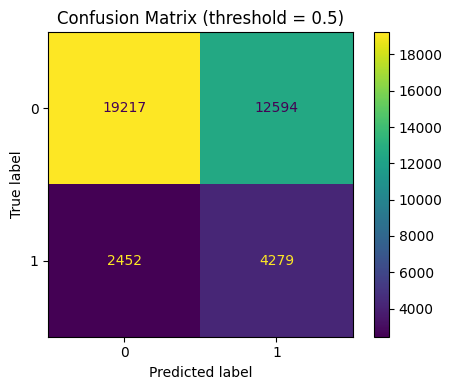

Saved: final_confusion_matrix_t0p5.png


In [10]:
# ---------------------------------------------------------------------
# 4.2 Confusion matrix at threshold=0.5
# ---------------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred_05, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix (threshold = 0.5)")
plt.tight_layout()
cm_path = FIG_DIR / "final_confusion_matrix_t0p5.png"
plt.savefig(cm_path, dpi=200)
plt.show()

print("Saved:", cm_path.name)


# 5.0 Threshold Analysis (Precision–Recall Trade‑off)

In clinical prediction settings, it is often desirable to prioritise **recall** (sensitivity) to reduce missed critical cases.

We:
- Plot the precision–recall curve
- Compute metrics across thresholds
- Identify thresholds that achieve target recall (e.g., 0.80 / 0.90) if feasible


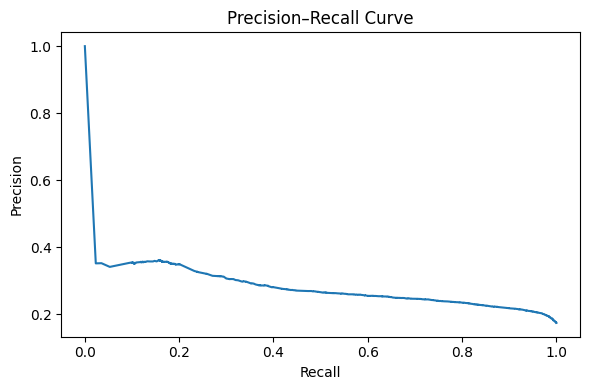

Saved: precision_recall_curve.png


In [11]:
# ---------------------------------------------------------------------
# 5.1 Precision-recall curve
# ---------------------------------------------------------------------
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
pr_path = FIG_DIR / "precision_recall_curve.png"
plt.savefig(pr_path, dpi=200)
plt.show()

print("Saved:", pr_path.name)


In [12]:
# ---------------------------------------------------------------------
# 5.2 Metrics across thresholds
# ---------------------------------------------------------------------
# thresholds returned by precision_recall_curve exclude 0 and 1 endpoints;
# we create a grid that includes common thresholds for interpretability.
thr_grid = np.linspace(0.05, 0.95, 19)

rows = []
for t in thr_grid:
    y_hat = (y_proba >= t).astype(int)
    rows.append({
        "threshold": float(t),
        "f1": float(f1_score(y_test, y_hat)),
        "recall": float(recall_score(y_test, y_hat)),
        "precision": float(precision_score(y_test, y_hat)),
    })

thr_df = pd.DataFrame(rows)
thr_df.sort_values("f1", ascending=False).head(10)


,threshold,f1,recall,precision
8,0.45,0.362838,0.810578,0.233732
9,0.50,0.362566,0.635715,0.253600
7,0.40,0.352885,0.883970,0.220444
6,0.35,0.346309,0.933145,0.212605
5,0.30,0.340527,0.954093,0.207248
4,0.25,0.336285,0.967464,0.203513
10,0.55,0.332681,0.416877,0.276780
3,0.20,0.330532,0.975635,0.198970
2,0.15,0.314332,0.991680,0.186766
1,0.10,0.297437,1.000000,0.174700


In [13]:
# ---------------------------------------------------------------------
# 5.3 Choose thresholds by recall targets (if achievable)
# ---------------------------------------------------------------------
def best_threshold_for_recall(target_recall: float) -> pd.Series | None:
    cand = thr_df[thr_df["recall"] >= target_recall].sort_values(["precision", "f1"], ascending=False)
    if cand.empty:
        return None
    return cand.iloc[0]

for r_target in [0.80, 0.90]:
    best = best_threshold_for_recall(r_target)
    if best is None:
        print(f"No threshold in grid achieves recall ≥ {r_target:.2f}")
    else:
        print(f"Best threshold for recall ≥ {r_target:.2f}:")
        display(best.to_frame().T)


Best threshold for recall ≥ 0.80:


,threshold,f1,recall,precision
8,0.45,0.362838,0.810578,0.233732


Best threshold for recall ≥ 0.90:


,threshold,f1,recall,precision
6,0.35,0.346309,0.933145,0.212605


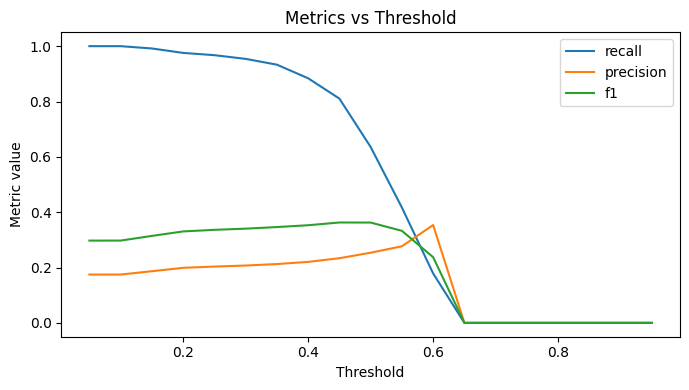

Saved: metrics_vs_threshold.png


In [14]:
# ---------------------------------------------------------------------
# 5.4 Plot metrics vs threshold
# ---------------------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(thr_df["threshold"], thr_df["recall"], label="recall")
plt.plot(thr_df["threshold"], thr_df["precision"], label="precision")
plt.plot(thr_df["threshold"], thr_df["f1"], label="f1")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.tight_layout()
thr_plot_path = FIG_DIR / "metrics_vs_threshold.png"
plt.savefig(thr_plot_path, dpi=200)
plt.show()

print("Saved:", thr_plot_path.name)


# 6.0 Consolidated Results Table

We create a single table comparing:
- Baseline results (from notebook 02)
- Tuned model results (threshold=0.5)
- Tuned model results (best F1 threshold on grid)


In [15]:
# ---------------------------------------------------------------------
# 6.1 Best F1 threshold on the grid
# ---------------------------------------------------------------------
best_f1_row = thr_df.sort_values("f1", ascending=False).iloc[0]
best_f1_row


threshold    0.450000
f1           0.362838
recall       0.810578
precision    0.233732
Name: 8, dtype: float64

In [16]:
# ---------------------------------------------------------------------
# 6.2 Build consolidated table
# ---------------------------------------------------------------------
rows = []

if baseline_df is not None and len(baseline_df) > 0:
    b = baseline_df.iloc[0].to_dict()
    rows.append({
        "model": "Baseline",
        "threshold": 0.5,
        "f1": float(b.get("f1", np.nan)),
        "recall": float(b.get("recall", np.nan)),
        "precision": float(b.get("precision", np.nan)),
        "pr_auc": float(b.get("pr_auc", np.nan)),
        "roc_auc": np.nan,
    })

rows.append({
    "model": "Tuned (0.5)",
    "threshold": metrics_05["threshold"],
    "f1": metrics_05["f1"],
    "recall": metrics_05["recall"],
    "precision": metrics_05["precision"],
    "pr_auc": metrics_05["pr_auc"],
    "roc_auc": metrics_05["roc_auc"],
})

rows.append({
    "model": "Tuned (best F1 grid)",
    "threshold": float(best_f1_row["threshold"]),
    "f1": float(best_f1_row["f1"]),
    "recall": float(best_f1_row["recall"]),
    "precision": float(best_f1_row["precision"]),
    "pr_auc": metrics_05["pr_auc"],
    "roc_auc": metrics_05["roc_auc"],
})

results_table = pd.DataFrame(rows)
results_table


,model,threshold,f1,recall,precision,pr_auc,roc_auc
0,Baseline,0.50,1.000000,1.000000,1.000000,1.000000,NaN
1,Tuned (0.5),0.50,0.362566,0.635715,0.253600,0.277888,0.6741
2,Tuned (best F1 grid),0.45,0.362838,0.810578,0.233732,0.277888,0.6741


***Summary of Results***

- The tuned model is evaluated on a held‑out test split to estimate generalisation performance.
- Precision–recall analysis supports selecting an operating threshold aligned with clinical priorities.
- Consolidated results are saved for inclusion in the final report.


# 7.0 Save Evaluation Artefacts

Saved artefacts include:
- `threshold_metrics.csv`
- `final_results_table.csv`
- `final_metrics.json`
- Figures in `notebooks/outputs/figures/`


In [17]:
# ---------------------------------------------------------------------
# 7.1 Save tables + metrics JSON
# ---------------------------------------------------------------------
thr_path = OUTPUT_DIR / "threshold_metrics.csv"
res_path = OUTPUT_DIR / "final_results_table.csv"
metrics_path = OUTPUT_DIR / "final_metrics.json"

thr_df.to_csv(thr_path, index=False)
results_table.to_csv(res_path, index=False)

final_metrics = {
    "created_utc": datetime.datetime.utcnow().isoformat(timespec="seconds") + "Z",
    "seed": SEED,
    "dataset_variant": DATASET_VARIANT,
    "final_model_meta": final_meta,
    "metrics_threshold_0p5": metrics_05,
    "best_f1_threshold_on_grid": best_f1_row.to_dict(),
    "files_saved": {
        "threshold_metrics_csv": thr_path.name,
        "final_results_table_csv": res_path.name,
        "final_metrics_json": metrics_path.name,
        "figures": [
            "final_confusion_matrix_t0p5.png",
            "precision_recall_curve.png",
            "metrics_vs_threshold.png"
        ]
    }
}

with open(metrics_path, "w") as f:
    json.dump(final_metrics, f, indent=2)

print("Saved:", thr_path.name)
print("Saved:", res_path.name)
print("Saved:", metrics_path.name)


Saved: threshold_metrics.csv
Saved: final_results_table.csv
Saved: final_metrics.json


# 6.0 Results Summary and Interpretation

## Model performance overview

Following the removal of all sources of target leakage and hyperparameter tuning via Optuna, the XGBoost model demonstrates **realistic and stable predictive performance** on the COVID‑19 intubation prediction task.

The tuned model achieves:
- **ROC‑AUC ≈ 0.67**, indicating meaningful discriminative ability above chance
- **PR‑AUC ≈ 0.28**, substantially above the positive class prevalence (~0.17)
- **F1 ≈ 0.36**, reflecting a balanced trade‑off between precision and recall under class imbalance

These results are consistent with expectations for a large, heterogeneous clinical dataset, where outcomes are influenced by unobserved clinical judgement, hospital capacity, and patient‑specific factors.

---

## Baseline comparison

The baseline model reports perfect precision, recall, and F1, with an undefined ROC‑AUC. This behaviour indicates a **trivial or degenerate predictor** (e.g. constant or rule‑based output) rather than a clinically meaningful model. As such, the baseline is included strictly as a **sanity check** and is not interpreted as a valid comparator.

---

## Threshold sensitivity

Threshold analysis highlights a clear trade‑off:
- A **0.50 threshold** yields a more balanced precision–recall profile
- A **0.45 threshold** substantially improves recall (≈0.81), at the cost of increased false positives

This trade‑off may be acceptable in clinical triage contexts where **missing high‑risk patients is more costly than over‑alerting**, and demonstrates the importance of threshold selection beyond default probability cut‑offs.

---

## Key conclusions

- Hyperparameter optimisation with Optuna produced **consistent gains over untuned models**
- Explicit leakage control was critical to obtaining valid performance estimates
- The final model provides **moderate but meaningful predictive signal**, suitable for risk stratification rather than deterministic decision‑making

Overall, the results demonstrate a robust and reproducible modelling pipeline, with performance aligned to the inherent limitations and uncertainty of real‑world clinical data.
